# 01__nearby_elems

in this notebook, i examine the relationship between cis/trans compensation and # of nearby regulatory elements

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from itertools import combinations 
from scipy.integrate import cumtrapz
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../../utils")
from plotting_utils import *


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## variables

In [5]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

In [6]:
hg19_elems_f = "../../../misc/03__nearby_elems/hg19.num_elems_1Mb.bed"
mm9_elems_f = "../../../misc/03__nearby_elems/mm9.num_elems_1Mb.bed"

In [7]:
hg19_tss_f = "../../../misc/03__nearby_elems/hg19.num_TSSs_1Mb.bed"
mm9_tss_f = "../../../misc/03__nearby_elems/mm9.num_TSSs_1Mb.bed"

In [8]:
hg19_enh_f = "../../../misc/03__nearby_elems/hg19.num_enhs_1Mb.bed"
mm9_enh_f = "../../../misc/03__nearby_elems/mm9.num_enhs_1Mb.bed"

## 1. import data

In [9]:
data = pd.read_table(data_f)
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect


In [10]:
hg19_elems = pd.read_table(hg19_elems_f, sep="\t", header=None)
hg19_tss = pd.read_table(hg19_tss_f, sep="\t", header=None)
hg19_enh = pd.read_table(hg19_enh_f, sep="\t", header=None)
hg19_elems.columns = ["chr", "start", "end", "name", "n_elems_hg19"]
hg19_tss.columns = ["chr", "start", "end", "name", "n_tss_hg19"]
hg19_enh.columns = ["chr", "start", "end", "name", "n_enh_hg19"]
hg19_elems.head()

,chr,start,end,name,n_elems_hg19
0,chr1,355317,2355461,HUMAN_EVO_TSS__h.1539__tile2;WT,531
1,chr1,355431,2355575,HUMAN_EVO_TSS__h.1539__tile1;WT,531
2,chr1,447313,2447457,HUMAN_EVO_TSS__h.3020__tile2;WT,549
3,chr1,447388,2447532,HUMAN_EVO_TSS__h.2871__tile1;WT,549
4,chr1,447427,2447571,HUMAN_EVO_TSS__h.3020__tile1;WT,549


In [11]:
mm9_elems = pd.read_table(mm9_elems_f, sep="\t", header=None)
mm9_tss = pd.read_table(mm9_tss_f, sep="\t", header=None)
mm9_enh = pd.read_table(mm9_enh_f, sep="\t", header=None)
mm9_elems.columns = ["chr", "start", "end", "name", "n_elems_mm9"]
mm9_tss.columns = ["chr", "start", "end", "name", "n_tss_mm9"]
mm9_enh.columns = ["chr", "start", "end", "name", "n_enh_mm9"]
mm9_elems.head()

,chr,start,end,name,n_elems_mm9
0,chr1,9983171,11983315,MOUSE_EVO_TSS__m.730__tile2;WT,57
1,chr1,9983285,11983429,MOUSE_EVO_TSS__m.730__tile1;WT,57
2,chr1,11981773,13981917,MOUSE_EVO_TSS__m.1555__tile2;WT,94
3,chr1,11981887,13982031,MOUSE_EVO_TSS__m.1555__tile1;WT,94
4,chr1,11982791,13982935,MOUSE_EVO_TSS__m.986__tile1;WT,94


## 2. join data w/ number of nearby elements

In [12]:
hg19_elems["hg19_id"] = hg19_elems["name"].str.split("__", expand=True)[1]
hg19_elems["tss_tile_num"] = hg19_elems["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
hg19_tss["hg19_id"] = hg19_tss["name"].str.split("__", expand=True)[1]
hg19_tss["tss_tile_num"] = hg19_tss["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
hg19_enh["hg19_id"] = hg19_enh["name"].str.split("__", expand=True)[1]
hg19_enh["tss_tile_num"] = hg19_enh["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
hg19_elems.head()

,chr,start,end,name,n_elems_hg19,hg19_id,tss_tile_num
0,chr1,355317,2355461,HUMAN_EVO_TSS__h.1539__tile2;WT,531,h.1539,tile2
1,chr1,355431,2355575,HUMAN_EVO_TSS__h.1539__tile1;WT,531,h.1539,tile1
2,chr1,447313,2447457,HUMAN_EVO_TSS__h.3020__tile2;WT,549,h.3020,tile2
3,chr1,447388,2447532,HUMAN_EVO_TSS__h.2871__tile1;WT,549,h.2871,tile1
4,chr1,447427,2447571,HUMAN_EVO_TSS__h.3020__tile1;WT,549,h.3020,tile1


In [13]:
mm9_elems["mm9_id"] = mm9_elems["name"].str.split("__", expand=True)[1]
mm9_elems["tss_tile_num"] = mm9_elems["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
mm9_tss["mm9_id"] = mm9_tss["name"].str.split("__", expand=True)[1]
mm9_tss["tss_tile_num"] = mm9_tss["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
mm9_enh["mm9_id"] = mm9_enh["name"].str.split("__", expand=True)[1]
mm9_enh["tss_tile_num"] = mm9_enh["name"].str.split("__", expand=True)[2].str.split(";", expand=True)[0]
mm9_elems.head()

,chr,start,end,name,n_elems_mm9,mm9_id,tss_tile_num
0,chr1,9983171,11983315,MOUSE_EVO_TSS__m.730__tile2;WT,57,m.730,tile2
1,chr1,9983285,11983429,MOUSE_EVO_TSS__m.730__tile1;WT,57,m.730,tile1
2,chr1,11981773,13981917,MOUSE_EVO_TSS__m.1555__tile2;WT,94,m.1555,tile2
3,chr1,11981887,13982031,MOUSE_EVO_TSS__m.1555__tile1;WT,94,m.1555,tile1
4,chr1,11982791,13982935,MOUSE_EVO_TSS__m.986__tile1;WT,94,m.986,tile1


In [14]:
len(data)

2952

In [15]:
data = data.merge(hg19_elems[["hg19_id", "tss_tile_num", "n_elems_hg19"]], on=["hg19_id", "tss_tile_num"], how="left")
data = data.merge(hg19_tss[["hg19_id", "tss_tile_num", "n_tss_hg19"]], on=["hg19_id", "tss_tile_num"], how="left")
data = data.merge(hg19_enh[["hg19_id", "tss_tile_num", "n_enh_hg19"]], on=["hg19_id", "tss_tile_num"], how="left")

data = data.merge(mm9_elems[["mm9_id", "tss_tile_num", "n_elems_mm9"]], on=["mm9_id", "tss_tile_num"], how="left")
data = data.merge(mm9_tss[["mm9_id", "tss_tile_num", "n_tss_mm9"]], on=["mm9_id", "tss_tile_num"], how="left")
data = data.merge(mm9_enh[["mm9_id", "tss_tile_num", "n_enh_mm9"]], on=["mm9_id", "tss_tile_num"], how="left")
print(len(data))
data.head()

2952


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,n_elems_hg19,n_tss_hg19,n_enh_hg19,n_elems_mm9,n_tss_mm9,n_enh_mm9
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect,345,267,78.0,318,244,74.0
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect,278,185,93.0,313,219,94.0
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect,418,343,75.0,510,357,153.0
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect,192,150,42.0,116,93,23.0
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect,192,150,42.0,116,93,23.0


## 3. look at overall numbers of nearby elems in human and mouse

In [16]:
# remove the 1 seq that is on chr1_random in mouse
data = data[~pd.isnull(data["n_elems_mm9"])]

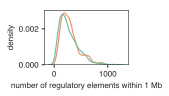

In [17]:
fig = plt.figure(figsize=(1.5, 1))

ax = sns.distplot(data["n_elems_hg19"], color=sns.color_palette("Set2")[1], label="human", hist=False)
sns.distplot(data["n_elems_mm9"], color=sns.color_palette("Set2")[0], label="mouse", hist=False)

ax.set_xlabel("number of regulatory elements within 1 Mb")
ax.set_ylabel("density")
ax.get_legend().remove()

# fig.savefig("n_elems_distplot.pdf", dpi="figure", bbox_inches="tight")

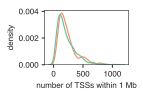

In [18]:
fig = plt.figure(figsize=(1.5, 1))

ax = sns.distplot(data["n_tss_hg19"], color=sns.color_palette("Set2")[1], label="human", hist=False)
sns.distplot(data["n_tss_mm9"], color=sns.color_palette("Set2")[0], label="mouse", hist=False)

ax.set_xlabel("number of TSSs within 1 Mb")
ax.set_ylabel("density")
ax.get_legend().remove()

# fig.savefig("n_tss_distplot.pdf", dpi="figure", bbox_inches="tight")

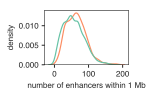

In [19]:
fig = plt.figure(figsize=(1.5, 1))

ax = sns.distplot(data["n_enh_hg19"], color=sns.color_palette("Set2")[1], label="human", hist=False)
sns.distplot(data["n_enh_mm9"], color=sns.color_palette("Set2")[0], label="mouse", hist=False)

ax.set_xlabel("number of enhancers within 1 Mb")
ax.set_ylabel("density")
ax.get_legend().remove()

# fig.savefig("n_enh_distplot.pdf", dpi="figure", bbox_inches="tight")

In [20]:
data["mean_elems"] = data[["n_elems_hg19", "n_elems_mm9"]].mean(axis=1)
data["mean_tss"] = data[["n_tss_hg19", "n_tss_mm9"]].mean(axis=1)
data["mean_enh"] = data[["n_enh_hg19", "n_enh_mm9"]].mean(axis=1)

## 4. assign directional vs. compensatory status and filter

In [21]:
def cis_trans_status(row):
    if row.cis_status_one == "significant cis effect":
        if row.trans_status_one == "significant trans effect":
            if "higher in human" in row.cis_status_det_one:
                if "higher in human" in row.trans_status_det_one:
                    return "cis/trans directional"
                else:
                    return "cis/trans compensatory"
            else:
                if "higher in human" in row.trans_status_det_one:
                    return "cis/trans compensatory"
                else:
                    return "cis/trans directional"
        else:
            return "cis effect only"
    else:
        if row.trans_status_one == "significant trans effect":
            return "trans effect only"
        else:
            return "no cis or trans effects"

In [22]:
data["cis_trans_status"] = data.apply(cis_trans_status, axis=1)
data.cis_trans_status.value_counts()

no cis or trans effects    1850
cis effect only             741
trans effect only           181
cis/trans directional       101
cis/trans compensatory       79
Name: cis_trans_status, dtype: int64

In [23]:
data = data[~pd.isnull(data["minimal_biotype_hg19"])]
len(data)

2952

In [24]:
data_filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

1655

In [25]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

1644

## 5. look at reg elems vs. cis/trans status

In [26]:
order = ["no cis or trans effects", "cis/trans compensatory", "cis effect only", "trans effect only",
         "cis/trans directional"]
min_order = ["cis/trans compensatory", "cis/trans directional"]
pal = {"no cis or trans effects": sns.color_palette("Set2")[7], "cis effect only": sns.color_palette("Set2")[2],
       "trans effect only": sns.color_palette("Set2")[2], "cis/trans directional": sns.color_palette("Set2")[2],
       "cis/trans compensatory": sns.color_palette("Set2")[7]}

### all REs

In [27]:
df = data_filt_sp

cis/trans compensatory median REs: 221.0
cis/trans directional median REs: 246.5


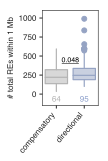

In [28]:
fig = plt.figure(figsize=(1, 1.75))

ax = sns.boxplot(data=df, x="cis_trans_status", y="mean_elems", order=min_order, 
                 flierprops = dict(marker='o', markersize=5), palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["compensatory", "directional"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("# total REs within 1 Mb")

for i, l in enumerate(min_order):
    sub = df[df["cis_trans_status"] == l]
    n = len(sub)
    print("%s median REs: %s" % (l, sub["mean_elems"].median()))
    color = pal[l]
    ax.annotate(str(n), xy=(i, -120), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

### pvals ###
vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["mean_elems"])
vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["mean_elems"])

vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

_, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)

annotate_pval(ax, 0.2, 0.8, 400, 0, 400, pval12, fontsize-1)

ax.set_ylim((-150, 1100))
fig.savefig("Fig6G.pdf", dpi="figure", bbox_inches="tight")

### TSSs only

cis/trans compensatory median REs: 148.25
cis/trans directional median REs: 170.0


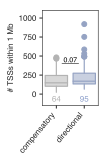

In [29]:
fig = plt.figure(figsize=(1, 1.75))

ax = sns.boxplot(data=df, x="cis_trans_status", y="mean_tss", order=min_order, 
                 flierprops = dict(marker='o', markersize=5), palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["compensatory", "directional"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("# TSSs within 1 Mb")

for i, l in enumerate(min_order):
    sub = df[df["cis_trans_status"] == l]
    n = len(sub)
    print("%s median REs: %s" % (l, sub["mean_tss"].median()))
    color = pal[l]
    ax.annotate(str(n), xy=(i, -120), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

### pvals ###
vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["mean_tss"])
vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["mean_tss"])

vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

_, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)

annotate_pval(ax, 0.2, 0.8, 400, 0, 400, pval12, fontsize-1)

ax.set_ylim((-150, 1100))
fig.savefig("Fig6I.pdf", dpi="figure", bbox_inches="tight")

### enhancers only

cis/trans compensatory median REs: 50.75
cis/trans directional median REs: 67.0


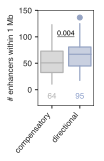

In [30]:
fig = plt.figure(figsize=(1, 1.75))

ax = sns.boxplot(data=df, x="cis_trans_status", y="mean_enh", order=min_order, 
                 flierprops = dict(marker='o', markersize=5), palette=pal)
mimic_r_boxplot(ax)

ax.set_xticklabels(["compensatory", "directional"], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("# enhancers within 1 Mb")

for i, l in enumerate(min_order):
    sub = df[df["cis_trans_status"] == l]
    n = len(sub)
    print("%s median REs: %s" % (l, sub["mean_enh"].median()))
    color = pal[l]
    ax.annotate(str(n), xy=(i, -20), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=color, size=fontsize)

### pvals ###
vals1 = np.asarray(df[df["cis_trans_status"] == "cis/trans compensatory"]["mean_enh"])
vals2 = np.asarray(df[df["cis_trans_status"] == "cis/trans directional"]["mean_enh"])

vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

_, pval12 = stats.mannwhitneyu(vals1, vals2, alternative="two-sided", use_continuity=False)

annotate_pval(ax, 0.2, 0.8, 100, 0, 100, pval12, fontsize-1)

ax.set_ylim((-30, 150))
fig.savefig("Fig6H.pdf", dpi="figure", bbox_inches="tight")